In [1]:
import sys
import os
sys.path.append("../pyfesom")

import pyfesom as pf
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import LinearSegmentedColormap, from_levels_and_colors
import numpy as np
#%matplotlib notebook
%matplotlib inline
from matplotlib import cm
from netCDF4 import Dataset, MFDataset
import xarray as xr
import pdb
import cmocean.cm as ocm
import glob
import pandas as pd
import matplotlib

No joblib
cartopy is not avalible, plotting will not work


In [2]:
def get_mesh(exp,cavity=False):
    masterPath='/albedo/work/projects/oce_rio/orichter/ollieWork/Misomip2/'
    meshpath  =os.path.join(masterPath,exp,'fesomInitialMesh')
    mesh = pf.fesom_mesh(meshpath, cavity=cavity)
    
    return mesh


In [3]:
masterPath='/albedo/work/projects/oce_rio/orichter/ollieWork/Misomip2/'
exp='oo0021'

mesh = get_mesh('oo0021')

dataPath=os.path.join(masterPath,exp,'fesomData','oo0021.2014-2018.oce.mean.nc')
oce = xr.open_dataset(dataPath)
temp = oce.temp.squeeze()
salt = oce.salt.squeeze()

dataPath=os.path.join(masterPath,exp,'fesomData','oo0021.2014-2018.wnetMean.nc')
frc = xr.open_dataset(dataPath)
wnet = frc.wnet.squeeze().load().where(mesh.cflag)*365.25*24*3600

Find bottom layer indices and save as bind
Find bottom layer indices and save as bind
Load 2d part of the grid in 2 second(s)
Find bottom layer indices and save as bind
Load 3d part of the grid in 16 seconds


In [4]:
region_amundsen=[-135,-85,-75.5,-71.5]
region_ptd=[-114.5,-99,-75.5,-74.1]

region = region_amundsen
mask=(mesh.x2>region[0]) & (mesh.x2<region[1]) & (mesh.y2>region[2]) & (mesh.y2<region[3])
wnet=wnet.where(mask)
temp=temp[0:mesh.n2d].where(mask).where(mesh.cflag)
salt=salt[0:mesh.n2d].where(mask).where(mesh.cflag)

meltDist=wnet[~np.isnan(wnet)].load()
tempDist=temp.load().values[~np.isnan(wnet)]
saltDist=salt.load().values[~np.isnan(wnet)]

zDist=-mesh.zcoord[0:mesh.n2d][(mask==1) & (mesh.cflag==1)]

In [5]:
a=-0.0573
b=0.0832
c=7.53e-4
TfDist=a*saltDist + b + c*zDist
TFDist = tempDist-TfDist

In [6]:
K=28.2

def RMSE(dt):
    mK=K*(TFDist+dt)*(np.mean(TFDist)+dt)
    return np.sqrt(np.mean((meltDist-mK)**2))


dts=np.arange(-3,3,0.01)
RMSEs=np.zeros_like(dts)
for i,dt in enumerate(dts):
    RMSEs[i]=RMSE(dt)
    
plt.plot(dts,RMSEs)
dt=dts[RMSEs==RMSEs.min()][0]
print(dts[RMSEs==RMSEs.min()])

[0.13]


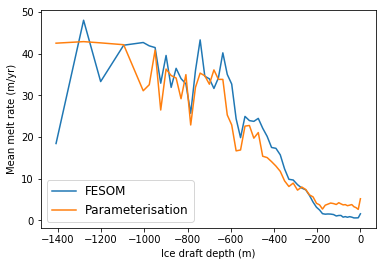

In [7]:
Tf=a*salt+b+c*-mesh.zcoord[0:mesh.n2d]
TF=temp-Tf
mK=K*(TF+dt)*(np.mean(TF)+dt)

mKDist=K*(TFDist+dt)*(np.mean(TFDist)+dt)
fig,ax=plt.subplots(figsize=(6,4))
matplotlib.rcParams.update({'font.size': 12})
xr.Dataset({'melt':(('depth'),meltDist)},coords={'depth':zDist}).groupby('depth').mean('depth').melt.plot(ax=ax,label='FESOM')
xr.Dataset({'melt':(('depth'),mKDist)},coords={'depth':zDist}).groupby('depth').mean('depth').melt.plot(ax=ax,label='Parameterisation')
ax.legend()
ax.set_xlabel('Ice draft depth (m)')
ax.set_ylabel('Mean melt rate (m/yr)')
plt.title('')

plt.savefig('./figures/meltParaEval.png',dpi=300,bbox_inches='tight')

In [3]:
#%config InlineBackend.figure_format = 'png'
#%config InlineBackend.dpi = 300
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid

def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero
    
    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower ofset). Should be between
          0.0 and 1.0.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax/(vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highets point in the colormap's range.
          Defaults to 1.0 (no upper ofset). Should be between
          0.0 and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }
      
    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])
    
    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))
        
    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

In [12]:
def get_coord(ax,mesh,region=False):
    if region==False:
        m=Basemap(projection='spstere',boundinglat=-65,lon_0=180)
        m.drawmapboundary(fill_color='0.9')
        x, y = m(mesh.x2, mesh.y2)
    else:
        x, y = mesh.x2, mesh.y2
        ax.set_xlim([region[0],region[1]])
        ax.set_ylim([region[2],region[3]])
    

    return ax,[x,y]

def get_bt_ax(ax,exp,mesh,coord,levels='max',fileHandle='2014-2018.oce.mean'):
    bidx=make_bidx(mesh)
    
    dataPath=os.path.join(masterPath,exp,'fesomData','%s.%s.nc'%(exp,fileHandle))
    oce = xr.open_dataset(dataPath)
    #pdb.set_trace()
    tbm = oce.temp.squeeze()[bidx].load()
    #coord[2].bluemarble()

    level_data, elem_no_nan = pf.get_data(tbm,mesh,0)
        
    if levels=='max':
        levels=np.arange(level_data.min(),level_data.max())
    else:
        levels = levels
        
    tpl = ax.tricontourf(coord[0], coord[1], elem_no_nan[::], level_data, levels = levels,
                         alpha=1.0, cmap=ocm.thermal, extend='both')
    
    #level_data, elem_no_nan = pf.get_data(mesh.cflag,mesh,0)
    #gl = ax.tricontour(coord[0], coord[1], elem_no_nan[::], level_data,
    #                     alpha=1.0,colors=['white'],linewidths=0.2)
    
    cbar = plt.colorbar(tpl,orientation='vertical', pad=0.01);
    cbar.set_label("Temperature, $^{\circ}$C")
    
    #ax.set_facecolor('gray')
    return ax,tpl

from matplotlib.colors import LogNorm
def get_wnet_ax(ax,exp,mesh,coord,levels='max',cmap=ocm.balance,shifted=True,fileHandle='2014-2018.wnetMean',ticks=False):
    
    dataPath=os.path.join(masterPath,exp,'fesomData','%s.%s.nc'%(exp,fileHandle))
    frc = xr.open_dataset(dataPath)
    wnet = frc.wnet.squeeze().load().where(mesh.cflag)*365.25*24*3600

    level_data, elem_no_nan = pf.get_data(wnet,mesh,0)
        
    if levels=='max':
        levels=np.arange(level_data.min(),level_data.max())
    else:
        levels = levels
    #pdb.set_trace()  
    level_data[level_data>max(levels)]=max(levels);
    level_data[level_data<min(levels)]=min(levels);
    
    if shifted:
        cmap = shiftedColorMap(cmap,midpoint = (1 - max(levels)/(max(levels) + abs(min(levels)))))
    
    wpl = ax.tricontourf(coord[0], coord[1], elem_no_nan[::], level_data, levels = levels,
                    cmap=cmap, extend='both')
    
    if ticks:
        cbar = plt.colorbar(wpl,ax=ax,orientation='vertical', pad=0.03,ticks=ticks);
    else:
        cbar = plt.colorbar(wpl,ax=ax,orientation='vertical', pad=0.03);
    cbar.set_label("Melt rate, m/yr")
    ax.set_ylabel('Latitude ($\circ$C)')
    ax.set_xlabel('Longitude ($\circ$C)')
    #ax.axis_ticks('off')
    
    
    return ax,wpl

def get_wnet_ax(ax,exp,mesh,coord,levels='max',cmap=ocm.balance,shifted=True,fileHandle='2014-2018.wnetMean',ticks=False):
    
    dataPath=os.path.join(masterPath,exp,'fesomData','%s.%s.nc'%(exp,fileHandle))
    frc = xr.open_dataset(dataPath)
    wnet = frc.wnet.squeeze().load().where(mesh.cflag)*365.25*24*3600

    level_data, elem_no_nan = pf.get_data(wnet,mesh,0)
        
    if levels=='max':
        levels=np.arange(level_data.min(),level_data.max())
    else:
        levels = levels
    #pdb.set_trace()  
    level_data[level_data>max(levels)]=max(levels);
    level_data[level_data<min(levels)]=min(levels);
    
    if shifted:
        cmap = shiftedColorMap(cmap,midpoint = (1 - max(levels)/(max(levels) + abs(min(levels)))))
    
    wpl = ax.tricontourf(coord[0], coord[1], elem_no_nan[::], level_data, levels = levels,
                    cmap=cmap, extend='both')
    
    if ticks:
        cbar = plt.colorbar(wpl,ax=ax,orientation='vertical', pad=0.03,ticks=ticks);
    else:
        cbar = plt.colorbar(wpl,ax=ax,orientation='vertical', pad=0.03);
    cbar.set_label("Melt rate, m/yr")
    ax.set_ylabel('Latitude ($\circ$C)')
    ax.set_xlabel('Longitude ($\circ$C)')
    #ax.axis_ticks('off')
    
    
    return ax,wpl

Find bottom layer indices and save as bind
Find bottom layer indices and save as bind
Load 2d part of the grid in 2 second(s)
Find bottom layer indices and save as bind
Load 3d part of the grid in 19 seconds


NameError: name 'get_coord' is not defined

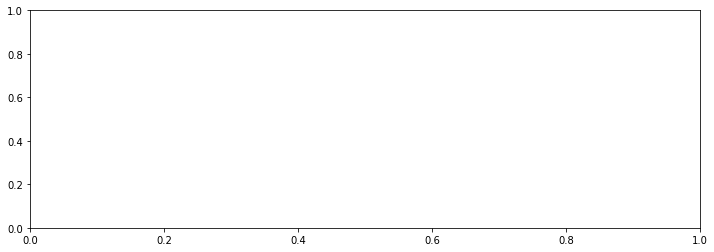

In [7]:
region_amundsen=[-135,-85,-75.5,-71.5]
region_ptd=[-114.5,-99,-75.5,-74.1]

mesh = get_mesh('oo0020')

fig,ax = plt.subplots(figsize=(12,4))
ax,coord=get_coord(ax,mesh,region=[-135,-85,-75.5,-71.5])
ax,wpl=get_wnet_ax(ax,'oo0020',mesh,coord,levels=np.arange(0.0,120,1),cmap=ocm.thermal,shifted=False)

fig,ax = plt.subplots(figsize=(12,4))
ax,coord=get_coord(ax,mesh,region=[-114.5,-99,-75.5,-74.1])
ax,wpl=get_wnet_ax(ax,'oo0020',mesh,coord,levels=np.arange(0.0,120,1),cmap=ocm.thermal,shifted=False)

In [358]:
masterPath='/albedo/work/projects/oce_rio/orichter/ollieWork/Misomip2/'
exp='oo0020'

dataPath=os.path.join(masterPath,exp,'fesomData','oo0020.2014-2018.tempMean.nc')
oce = xr.open_dataset(dataPath)
temp = oce.temp.squeeze()

dataPath=os.path.join(masterPath,exp,'fesomData','oo0020.2014-2018.saltMean.nc')
oce = xr.open_dataset(dataPath)
salt = oce.salt.squeeze()

dataPath=os.path.join(masterPath,exp,'fesomData','oo0020.2014-2018.wnetMean.nc')
frc = xr.open_dataset(dataPath)
wnet = frc.wnet.squeeze().load().where(mesh.cflag)*365.25*24*3600

In [359]:
region = region_amundsen
mask=(mesh.x2>region[0]) & (mesh.x2<region[1]) & (mesh.y2>region[2]) & (mesh.y2<region[3])
wnet=wnet.where(mask)
temp=temp[0:mesh.n2d].where(mask).where(mesh.cflag)
salt=salt[0:mesh.n2d].where(mask).where(mesh.cflag)

meltDist=wnet[~np.isnan(wnet)].load()
tempDist=temp.load().values[~np.isnan(wnet)]
saltDist=salt.load().values[~np.isnan(wnet)]

zDist=-mesh.zcoord[0:mesh.n2d][(mask==1) & (mesh.cflag==1)]

In [360]:
a=-0.0573
b=0.0832
c=7.53e-4
TfDist=a*saltDist + b + c*zDist
TFDist = tempDist-TfDist

In [361]:
K=28.2

def RMSE(dt):
    mK=K*(TFDist+dt)*(np.mean(TFDist)+dt)
    return np.sqrt(np.mean((meltDist-mK)**2))


dts=np.arange(-3,3,0.01)
RMSEs=np.zeros_like(dts)
for i,dt in enumerate(dts):
    RMSEs[i]=RMSE(dt)
    
plt.plot(dts,RMSEs)
dt=dts[RMSEs==RMSEs.min()][0]
print(dts[RMSEs==RMSEs.min()])

[0.38]


For depth 0 model level 0.0 will be used


/albedo/home/orichter/.conda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """
/albedo/home/orichter/.conda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
/albedo/home/orichter/.conda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()


For depth 0 model level 0.0 will be used


/albedo/home/orichter/.conda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:52: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/albedo/home/orichter/.conda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/albedo/home/orichter/.conda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in less


Text(0.5,1,'oo0020, Cdx10, FESOM')

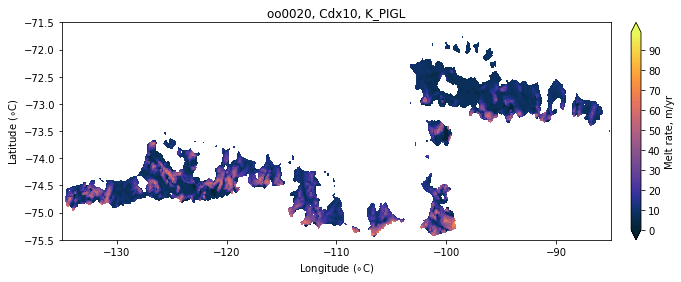

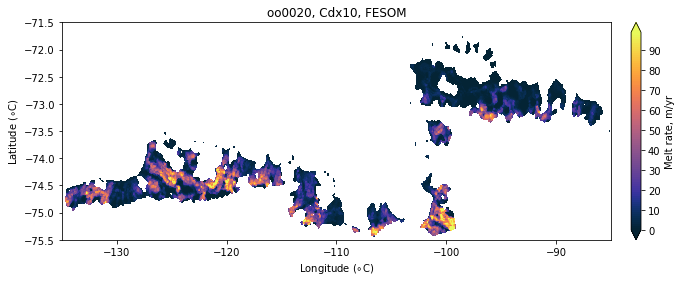

In [362]:
Tf=a*salt+b+c*-mesh.zcoord[0:mesh.n2d]
TF=temp-Tf
mK=K*(TF+dt)*(np.mean(TF)+dt)

fig,ax = plt.subplots(figsize=(12,4))
ax,coord=get_coord(ax,mesh,region=[-135,-85,-75.5,-71.5])
ax,wpl=get_mK_ax(ax,'oo0020',mesh,coord,levels=np.arange(0.0,100,1),cmap=ocm.thermal,shifted=False)
plt.title('oo0020, Cdx10, K_PIGL')

fig,ax = plt.subplots(figsize=(12,4))
ax,coord=get_coord(ax,mesh,region=[-135,-85,-75.5,-71.5])
ax,wpl=get_wnet_ax(ax,'oo0020',mesh,coord,levels=np.arange(0.0,100,1),cmap=ocm.thermal,shifted=False)
plt.title('oo0020, Cdx10, FESOM')

Text(0.5,1,'oo0020, CDx10')

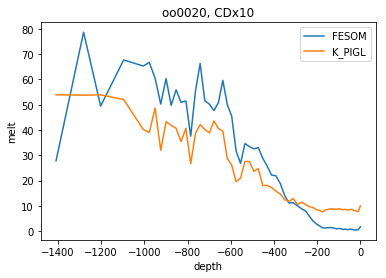

In [363]:
mKDist=K*(TFDist+dt)*(np.mean(TFDist)+dt)
fig,ax=plt.subplots()
xr.Dataset({'melt':(('depth'),meltDist)},coords={'depth':zDist}).groupby('depth').mean('depth').melt.plot(ax=ax,label='FESOM')
xr.Dataset({'melt':(('depth'),mKDist)},coords={'depth':zDist}).groupby('depth').mean('depth').melt.plot(ax=ax,label='K_PIGL')
ax.legend()
plt.title('oo0020, CDx10')

NameError: name 'get_mK_ax' is not defined

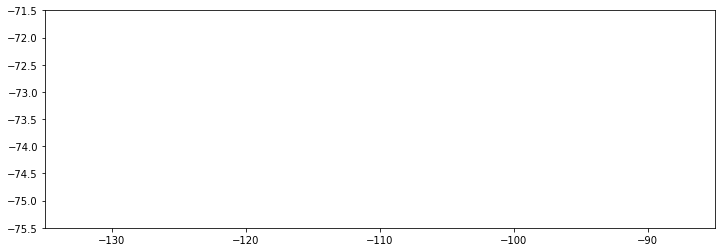

In [13]:
Tf=a*salt+b+c*-mesh.zcoord[0:mesh.n2d]
TF=temp-Tf
mK=K*(TF+dt)*(np.mean(TF)+dt)

fig,ax = plt.subplots(figsize=(12,4))
ax,coord=get_coord(ax,mesh,region=[-135,-85,-75.5,-71.5])
ax,wpl=get_mK_ax(ax,'oo0021',mesh,coord,levels=np.arange(0.0,100,1),cmap=ocm.thermal,shifted=False)
plt.title('oo0021, Cdx5, K_PIGL')

fig,ax = plt.subplots(figsize=(12,4))
ax,coord=get_coord(ax,mesh,region=[-135,-85,-75.5,-71.5])
ax,wpl=get_wnet_ax(ax,'oo0021',mesh,coord,levels=np.arange(0.0,100,1),cmap=ocm.thermal,shifted=False)
plt.title('oo0020, Cdx10, FESOM')

In [370]:
masterPath='/albedo/work/projects/oce_rio/orichter/ollieWork/Misomip2/'
exp='oo0012'

dataPath=os.path.join(masterPath,exp,'fesomData','oo0012.2014-2018.oce.mean.nc')
oce = xr.open_dataset(dataPath)
temp = oce.temp.squeeze()
salt = oce.salt.squeeze()

dataPath=os.path.join(masterPath,exp,'fesomData','oo0012.2014-2018.wnet.mean.nc')
frc = xr.open_dataset(dataPath)
wnet = frc.wnet.squeeze().load().where(mesh.cflag)*365.25*24*3600

In [371]:
region = region_amundsen
mask=(mesh.x2>region[0]) & (mesh.x2<region[1]) & (mesh.y2>region[2]) & (mesh.y2<region[3])
wnet=wnet.where(mask)
temp=temp[0:mesh.n2d].where(mask).where(mesh.cflag)
salt=salt[0:mesh.n2d].where(mask).where(mesh.cflag)

meltDist=wnet[~np.isnan(wnet)].load()
tempDist=temp.load().values[~np.isnan(wnet)]
saltDist=salt.load().values[~np.isnan(wnet)]

zDist=-mesh.zcoord[0:mesh.n2d][(mask==1) & (mesh.cflag==1)]

In [372]:
a=-0.0573
b=0.0832
c=7.53e-4
TfDist=a*saltDist + b + c*zDist
TFDist = tempDist-TfDist

[-0.42]


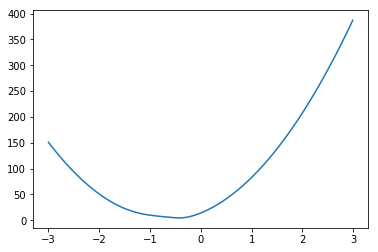

In [373]:
K=28.2

def RMSE(dt):
    mK=K*(TFDist+dt)*(np.mean(TFDist)+dt)
    return np.sqrt(np.mean((meltDist-mK)**2))


dts=np.arange(-3,3,0.01)
RMSEs=np.zeros_like(dts)
for i,dt in enumerate(dts):
    RMSEs[i]=RMSE(dt)
    
plt.plot(dts,RMSEs)
dt=dts[RMSEs==RMSEs.min()][0]
print(dts[RMSEs==RMSEs.min()])

For depth 0 model level 0.0 will be used


/albedo/home/orichter/.conda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """
/albedo/home/orichter/.conda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
/albedo/home/orichter/.conda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()


For depth 0 model level 0.0 will be used


/albedo/home/orichter/.conda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:52: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/albedo/home/orichter/.conda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/albedo/home/orichter/.conda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in less


Text(0.5,1,'oo0012, Cdx1, FESOM')

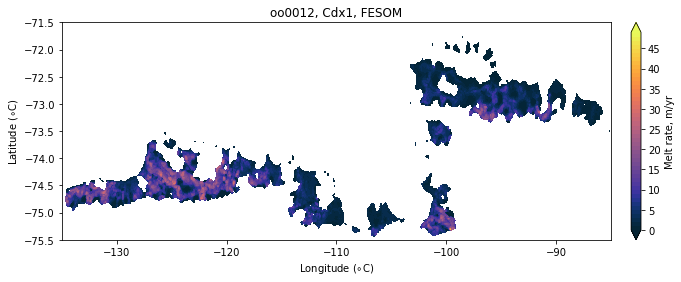

In [374]:
Tf=a*salt+b+c*-mesh.zcoord[0:mesh.n2d]
TF=temp-Tf
mK=K*(TF+dt)*(np.mean(TF)+dt)

fig,ax = plt.subplots(figsize=(12,4))
ax,coord=get_coord(ax,mesh,region=[-135,-85,-75.5,-71.5])
ax,wpl=get_mK_ax(ax,'oo0012',mesh,coord,levels=np.arange(0.0,50,1),cmap=ocm.thermal,shifted=False)
plt.title('oo0012, Cdx1, K_PIGL')

fig,ax = plt.subplots(figsize=(12,4))
ax,coord=get_coord(ax,mesh,region=[-135,-85,-75.5,-71.5])
ax,wpl=get_wnet_ax(ax,'oo0012',mesh,coord,levels=np.arange(0.0,50,1),cmap=ocm.thermal,shifted=False,fileHandle='2014-2018.wnet.mean')
plt.title('oo0012, Cdx1, FESOM')

In [375]:
mKDist=K*(TFDist+dt)*(np.mean(TFDist)+dt)
fig,ax=plt.subplots()
xr.Dataset({'melt':(('depth'),meltDist)},coords={'depth':zDist}).groupby('depth').mean('depth').melt.plot(ax=ax,label='FESOM')
xr.Dataset({'melt':(('depth'),mKDist)},coords={'depth':zDist}).groupby('depth').mean('depth').melt.plot(ax=ax,label='K_PIGL')
ax.legend()
plt.title('oo0012, CDx1')

Text(0.5,1,'oo0012, CDx1')

In [399]:
def get_wnet_ax(ax,exp,mesh,coord,levels='max',cmap=ocm.balance,shifted=True,fileHandle='2014-2018.wnetMean',ticks=False):
    
    dataPath=os.path.join(masterPath,exp,'fesomData','%s.%s.nc'%(exp,fileHandle))
    frc = xr.open_dataset(dataPath)
    wnet = frc.wnet.mean('T').load().where(mesh.cflag)*365.25*24*3600

    level_data, elem_no_nan = pf.get_data(wnet,mesh,0)
        
    if levels=='max':
        levels=np.arange(level_data.min(),level_data.max())
    else:
        levels = levels
    #pdb.set_trace()  
    level_data[level_data>max(levels)]=max(levels);
    level_data[level_data<min(levels)]=min(levels);
    
    if shifted:
        cmap = shiftedColorMap(cmap,midpoint = (1 - max(levels)/(max(levels) + abs(min(levels)))))
    
    wpl = ax.tricontourf(coord[0], coord[1], elem_no_nan[::], level_data, levels = levels,
                    cmap=cmap, extend='both')
    
    if ticks:
        cbar = plt.colorbar(wpl,ax=ax,orientation='vertical', pad=0.03,ticks=ticks);
    else:
        cbar = plt.colorbar(wpl,ax=ax,orientation='vertical', pad=0.03);
    cbar.set_label("Melt rate, m/yr")
    ax.set_ylabel('Latitude ($\circ$C)')
    ax.set_xlabel('Longitude ($\circ$C)')
    #ax.axis_ticks('off')
    
    
    return ax,wpl

For depth 0 model level 0.0 will be used


/albedo/home/orichter/.conda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if __name__ == '__main__':
/albedo/home/orichter/.conda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  
/albedo/home/orichter/.conda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app


For depth 0 model level 0.0 will be used


Text(0.5,1,'oo0020, Cdx10, ERA-INT, 1980')

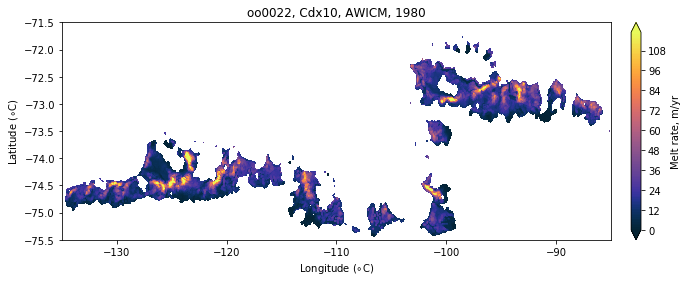

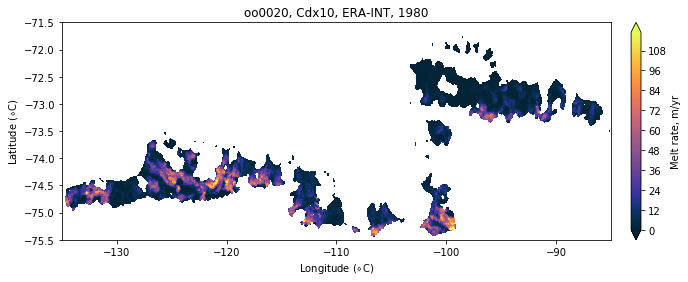

In [404]:
fig,ax = plt.subplots(figsize=(12,4))
ax,coord=get_coord(ax,mesh,region=[-135,-85,-75.5,-71.5])
ax,wpl=get_wnet_ax(ax,'oo0022',mesh,coord,levels=np.arange(0.0,120,1),cmap=ocm.thermal,shifted=False,fileHandle='1980.forcing.diag')
plt.title('oo0022, Cdx10, AWICM, 1980')

fig,ax = plt.subplots(figsize=(12,4))
ax,coord=get_coord(ax,mesh,region=[-135,-85,-75.5,-71.5])
ax,wpl=get_wnet_ax(ax,'oo0020',mesh,coord,levels=np.arange(0.0,120,1),cmap=ocm.thermal,shifted=False,fileHandle='1980.forcing.diag')
plt.title('oo0020, Cdx10, ERA-INT, 1980')

IOError: [Errno 2] No such file or directory: '/albedo/work/projects/oce_rio/orichter/ollieWork/Misomip2/oo0021/fesomData/oo0021.1980.forcing.diag.nc'

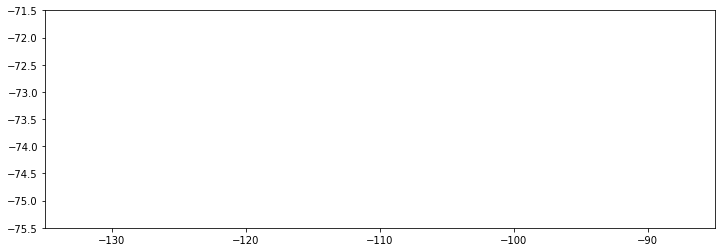

In [403]:
fig,ax = plt.subplots(figsize=(12,4))
ax,coord=get_coord(ax,mesh,region=[-135,-85,-75.5,-71.5])
ax,wpl=get_wnet_ax(ax,'oo0021',mesh,coord,levels=np.arange(0.0,120,1),cmap=ocm.thermal,shifted=False,fileHandle='1980.forcing.diag')
plt.title('oo0022, ')

fig,ax = plt.subplots(figsize=(12,4))
ax,coord=get_coord(ax,mesh,region=[-135,-85,-75.5,-71.5])
ax,wpl=get_wnet_ax(ax,'oo0023',mesh,coord,levels=np.arange(0.0,120,1),cmap=ocm.thermal,shifted=False,fileHandle='1980.forcing.diag')
plt.title('oo0020, Cdx1, FESOM')

In [401]:
fig,ax = plt.subplots(figsize=(12,4))
ax,coord=get_coord(ax,mesh,region=[-135,-85,-75.5,-71.5])
ax,wpl=get_wnet_ax(ax,'oo0020',mesh,coord,levels=np.arange(0.0,120,1),cmap=ocm.thermal,shifted=False,fileHandle='1980.forcing.diag')

For depth 0 model level 0.0 will be used


/albedo/home/orichter/.conda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if __name__ == '__main__':
/albedo/home/orichter/.conda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  
/albedo/home/orichter/.conda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app


For depth 0 model level 0.0 will be used


For depth 0 model level 0.0 will be used


/albedo/home/orichter/.conda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:52: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/albedo/home/orichter/.conda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/albedo/home/orichter/.conda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in less


For depth 0 model level 0.0 will be used


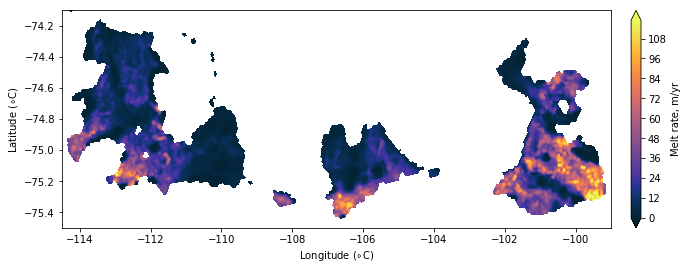

In [113]:
region_amundsen=[-135,-85,-75.5,-71.5]
region_ptd=[-114.5,-99,-75.5,-74.1]

mesh = get_mesh('oo0020')

fig,ax = plt.subplots(figsize=(12,4))
ax,coord=get_coord(ax,mesh,region=[-135,-85,-75.5,-71.5])
ax,wpl=get_wnet_ax(ax,'oo0020',mesh,coord,levels=np.arange(0.0,120,1),cmap=ocm.thermal,shifted=False)

fig,ax = plt.subplots(figsize=(12,4))
ax,coord=get_coord(ax,mesh,region=[-114.5,-99,-75.5,-74.1])
ax,wpl=get_wnet_ax(ax,'oo0020',mesh,coord,levels=np.arange(0.0,120,1),cmap=ocm.thermal,shifted=False)

In [376]:
masterPath='/albedo/work/projects/oce_rio/orichter/ollieWork/Misomip2/'
exp='oo0020'

dataPath=os.path.join(masterPath,exp,'fesomData','oo0020.2014-2018.tempMean.nc')
oce = xr.open_dataset(dataPath)
temp = oce.temp.squeeze()

dataPath=os.path.join(masterPath,exp,'fesomData','oo0020.2014-2018.saltMean.nc')
oce = xr.open_dataset(dataPath)
salt = oce.salt.squeeze()

dataPath=os.path.join(masterPath,exp,'fesomData','oo0020.2014-2018.wnetMean.nc')
frc = xr.open_dataset(dataPath)
wnet = frc.wnet.squeeze().load().where(mesh.cflag)*365.25*24*3600

In [378]:
region = region_amundsen
mask=(mesh.x2>region[0]) & (mesh.x2<region[1]) & (mesh.y2>region[2]) & (mesh.y2<region[3])
wnet=wnet.where(mask)
temp=temp[0:mesh.n2d].where(mask).where(mesh.cflag)
salt=salt[0:mesh.n2d].where(mask).where(mesh.cflag)

meltDist=wnet[~np.isnan(wnet)].load()
tempDist=temp.load().values[~np.isnan(wnet)]
saltDist=salt.load().values[~np.isnan(wnet)]

zDist=-mesh.zcoord[0:mesh.n2d][(mask==1) & (mesh.cflag==1)]

a=-0.0573
b=0.0832
c=7.53e-4
TfDist=a*saltDist + b + c*zDist
TFDist = tempDist-TfDist

In [382]:
KDist=meltDist/(TFDist*np.mean(TFDist))

import numpy as np
from scipy.interpolate import UnivariateSpline
from matplotlib import pyplot as plt

N = 1000
n=N//10

p, x = np.histogram(KDist, bins=n,range=(-500,500))
x = x[:-1] + (x[1] - x[0])/2
f = UnivariateSpline(x, p, s=n)
plt.plot(x,f(x))
#plt.xlim(-0.1e7,0.1e7)
plt.show()

print(x[p==max(p)])

[35.]


In [391]:
K=35

def RMSE(dt):
    mK=K*(TFDist+dt)*(np.mean(TFDist)+dt)
    return np.sqrt(np.mean((meltDist-mK)**2))


dts=np.arange(-3,3,0.01)
RMSEs=np.zeros_like(dts)
for i,dt in enumerate(dts):
    RMSEs[i]=RMSE(dt)
    
plt.plot(dts,RMSEs)
dt=dts[RMSEs==RMSEs.min()][0]
print(dts[RMSEs==RMSEs.min()])

[0.29]


For depth 0 model level 0.0 will be used


/albedo/home/orichter/.conda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """
/albedo/home/orichter/.conda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
/albedo/home/orichter/.conda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()


For depth 0 model level 0.0 will be used


/albedo/home/orichter/.conda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:52: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/albedo/home/orichter/.conda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/albedo/home/orichter/.conda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in less


Text(0.5,1,'oo0020, Cdx10, FESOM')

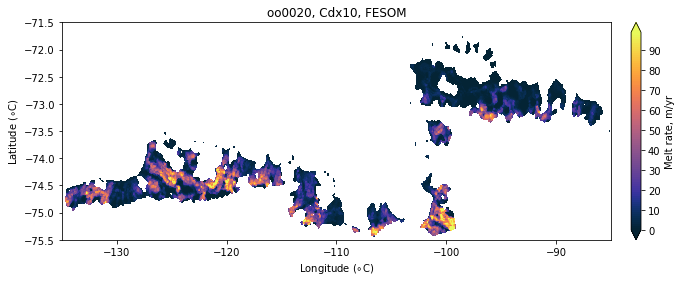

In [392]:
Tf=a*salt+b+c*-mesh.zcoord[0:mesh.n2d]
TF=temp-Tf
mK=K*(TF+dt)*(np.mean(TF)+dt)

fig,ax = plt.subplots(figsize=(12,4))
ax,coord=get_coord(ax,mesh,region=[-135,-85,-75.5,-71.5])
ax,wpl=get_mK_ax(ax,'oo0020',mesh,coord,levels=np.arange(0.0,100,1),cmap=ocm.thermal,shifted=False)
plt.title('oo0020, Cdx10, K_ole')

fig,ax = plt.subplots(figsize=(12,4))
ax,coord=get_coord(ax,mesh,region=[-135,-85,-75.5,-71.5])
ax,wpl=get_wnet_ax(ax,'oo0020',mesh,coord,levels=np.arange(0.0,100,1),cmap=ocm.thermal,shifted=False)
plt.title('oo0020, Cdx10, FESOM')

Text(0.5,1,'oo0020, CDx10')

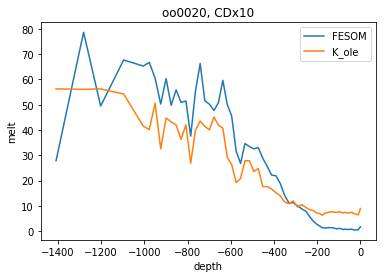

In [393]:
mKDist=K*(TFDist+dt)*(np.mean(TFDist)+dt)
fig,ax=plt.subplots()
xr.Dataset({'melt':(('depth'),meltDist)},coords={'depth':zDist}).groupby('depth').mean('depth').melt.plot(ax=ax,label='FESOM')
xr.Dataset({'melt':(('depth'),mKDist)},coords={'depth':zDist}).groupby('depth').mean('depth').melt.plot(ax=ax,label='K_ole')
ax.legend()
plt.title('oo0020, CDx10')

In [380]:

KDist

<xarray.DataArray 'wnet' (nodes_2d: 25718)>
array([ 51.916713,  75.950798, 292.863497, ..., 110.67005 , 150.065715,
       114.801556])
Dimensions without coordinates: nodes_2d

In [ ]:
def get_mK_ax(ax,exp,mesh,coord,levels='max',cmap=ocm.balance,shifted=True,ticks=False):
    

    wnet = frc.wnet.squeeze().load().where(mesh.cflag)*365.25*24*3600

    level_data, elem_no_nan = pf.get_data(wnet,mesh,0)
        
    if levels=='max':
        levels=np.arange(level_data.min(),level_data.max())
    else:
        levels = levels
    #pdb.set_trace()  
    level_data[level_data>max(levels)]=max(levels);
    level_data[level_data<min(levels)]=min(levels);
    
    if shifted:
        cmap = shiftedColorMap(cmap,midpoint = (1 - max(levels)/(max(levels) + abs(min(levels)))))
    
    wpl = ax.tricontourf(coord[0], coord[1], elem_no_nan[::], level_data, levels = levels,
                    cmap=cmap, extend='both')
    
    if ticks:
        cbar = plt.colorbar(wpl,ax=ax,orientation='vertical', pad=0.03,ticks=ticks);
    else:
        cbar = plt.colorbar(wpl,ax=ax,orientation='vertical', pad=0.03);
    cbar.set_label("Melt rate, m/yr")
    ax.set_ylabel('Latitude ($\circ$C)')
    ax.set_xlabel('Longitude ($\circ$C)')
    #ax.axis_ticks('off')
    
    
    return ax,wpl

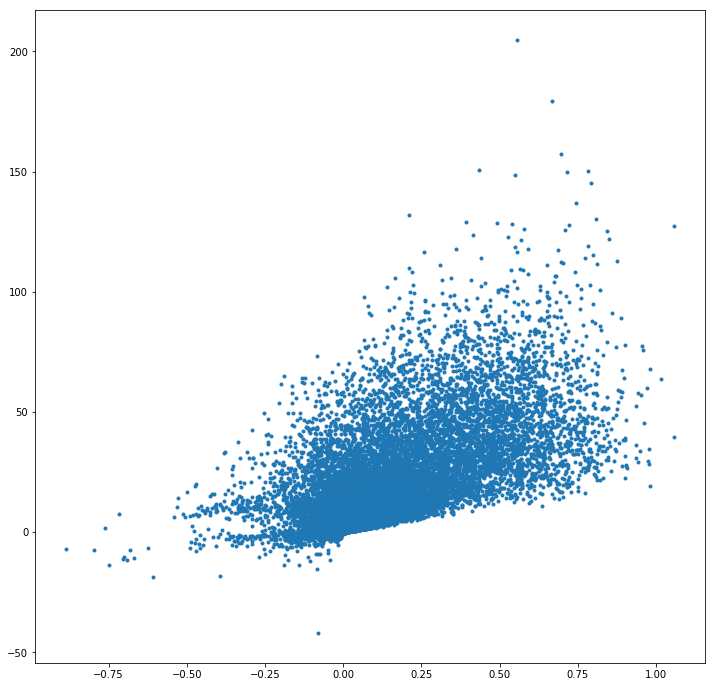

In [148]:
plt.figure(figsize=(12,12))
plt.plot(TFDist*np.abs(np.mean(TFDist)),meltDist,'.')

<xarray.DataArray 'wnet' (nodes_2d: 25718)>
array([ 51.916713,  75.950798, 292.863497, ..., 110.67005 , 150.065715,
       114.801556])
Dimensions without coordinates: nodes_2d

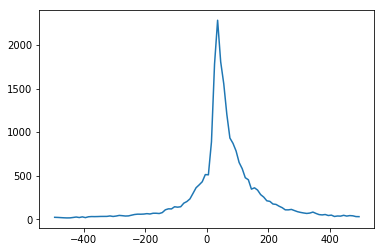

In [231]:
import numpy as np
from scipy.interpolate import UnivariateSpline
from matplotlib import pyplot as plt

N = 1000
n=N//10

p, x = np.histogram(KDist, bins=n,range=(-500,500))
x = x[:-1] + (x[1] - x[0])/2
f = UnivariateSpline(x, p, s=n)
plt.plot(x,f(x))
#plt.xlim(-0.1e7,0.1e7)
plt.show()

In [233]:
x[p==max(p)]

array([35.])

In [144]:
K_pigl=28.2
mkDist=K*(TFDist+dT)*np.mean(TFDist+dT)

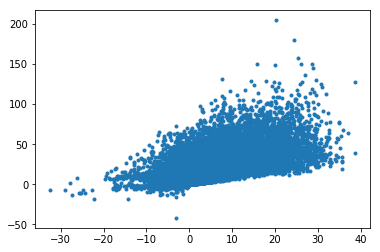

In [146]:
plt.plot(K*TF,meltDist,'.')

In [130]:
np.mean(KDist)

<xarray.DataArray 'wnet' ()>
array(541.377224)

In [ ]:
melt = K*

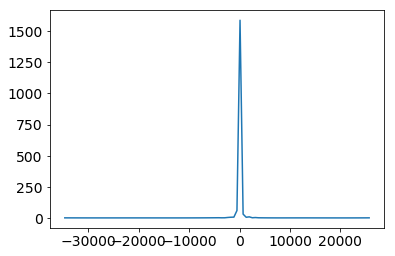

In [97]:
import numpy as np
from scipy.interpolate import UnivariateSpline
from matplotlib import pyplot as plt

N = 1000
n=N//10

p, x = np.histogram(KDist, bins=n)
x = x[:-1] + (x[1] - x[0])/2
f = UnivariateSpline(x, p, s=n)
plt.plot(x,f(x))
plt.show()

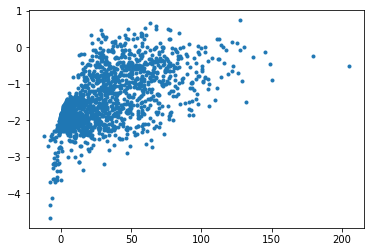

In [37]:
plt.plot(meltDist,tempDist,'.')
plt.show()